In [47]:
!git add C2_RNN_unstable_gradients.ipynb
!git commit -m "RNN unstable gradients checkin"
!git push

The file will have its original line endings in your working directory


[master 7096a39] RNN unstable gradients checkin
 1 file changed, 402 insertions(+), 350 deletions(-)
 rewrite 2_DNN_TF/C2_RNN_unstable_gradients.ipynb (74%)


To https://github.com/auslei/python.git
   ef1228a..7096a39  master -> master


## Rcurent Neural Networks - Layer Normalisation

RNN suffers from unstable gradient problem. The common non-saturating activation functions may not work and lead to explosive gradient, as the neuron output is also related all previous inputs. Batch normalisation (apply normalisation after output to improve signal) will work only between RNN layers but not within timesteps, this does not improve result much. An alternative normalisation is called *layer normalisation*, which normalising across features rather than batch, which can be effective. Normally used right after the linear combination of inputs and hidden states.

In [37]:
## generate test data
import numpy as np
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 + np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) #wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

n_steps = 50
series = generate_time_series(10000, n_steps + 10) # returns numpy array of [batch_size, timestep, 1] - univariate dataset

## Create a custom RNN layer with Layer Normalisation

In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RNN, SimpleRNN, Dense, LSTM

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation = "tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation = None) # simple RNN cell, without activation
        self.layer_norm = keras.layers.LayerNormalization() # normalisation is done before activation
        self.activation = keras.activations.get(activation)
    
    # links everything together
    def call(self, inputs, states):  #current inputs and previous hidden states
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs] # the return value is output and new hidden states

## Train RNN to forcast serveral timesteps ahead

### Series to Vector: Passing a series and returns of a vector

In [39]:
keras.backend.clear_session()

# get series to vector
X_train, y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

model = Sequential([    
    RNN(LNSimpleRNNCell(20), return_sequences = True, input_shape = [None, 1]),
    RNN(LNSimpleRNNCell(20)),
    Dense(10)
])

es_cb = keras.callbacks.EarlyStopping(patience=5, min_delta = 1e3)

model.compile(loss = 'mse', optimizer = 'adam')
history = model.fit(X_train, y_train, callbacks = es_cb, validation_data=(X_valid, y_valid), 
                     epochs = 30, verbose = False)
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 7ms/step - loss: 0.0391


0.03913715109229088

### Series to Series

Instead of returning a vector of the next # of steps, instead we can return the next # steps for each of the timestep. This is called series to series.

In [40]:
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):   # each target is a 10D vector (for each step, get the next 10 steps)
    Y[:, :, step_ahead - 1] = series[:, step_ahead : step_ahead + n_steps, 0]  # for each of the 10 targets in y, shift x across 10 steps and take the next 10 value
    
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [41]:
keras.backend.clear_session()

model2 = Sequential([
    RNN(LNSimpleRNNCell(20), return_sequences = True, input_shape = [None, 1]),
    RNN(LNSimpleRNNCell(20), return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model2.summary()

# note as we are predicting next 10 values, only the last set of values are required to calc mse
def last_time_step_mse(Y_true, y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], y_pred[:, -1])

model2.compile(loss = last_time_step_mse, optimizer = 'adam')
history = model2.fit(X_train, Y_train, callbacks = es_cb, validation_data=(X_valid, Y_valid), 
                     epochs = 30, verbose = False)
model2.evaluate(X_test, Y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn (RNN)                    (None, None, 20)          480       
_________________________________________________________________
rnn_1 (RNN)                  (None, None, 20)          860       
_________________________________________________________________
time_distributed (TimeDistri (None, None, 10)          210       
Total params: 1,550
Trainable params: 1,550
Non-trainable params: 0
_________________________________________________________________
32/32 [==============================] - 0s 7ms/step - loss: 0.0246


0.024561041966080666

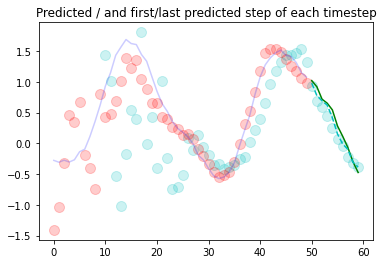

In [42]:
from matplotlib import pyplot as plt
Y_pred = model2.predict(X_test[:1])

plt.title("Predicted / and first/last predicted step of each timestep")
plt.plot(np.arange(50), X_test[:1].squeeze(), c = 'b', alpha = 0.2)
plt.plot(np.arange(60)[-10:], Y_test[:1, -1:, :].squeeze(), c = 'g')
plt.plot(np.arange(60)[-10:], Y_pred[:1, -1:, :].squeeze(), c = 'c', linestyle = '--')
for i in range(50):
    yp = Y_pred[:1, i, :1].squeeze()
    yp2 = Y_pred[:1, i, -1:].squeeze()
    plt.scatter(i, yp, s = 100, c = 'r', alpha = 0.2)
    plt.scatter(i + 10, yp2, s = 100, c = 'c', alpha = 0.2)

## Short-term memory problem
Due to the transformation that goes into place when tranversing through RNN, some information will be lost at each step, after a while the information maybe totally lost. To tackle this problem various cells with long time memory has been introduced. 

**Long Short-Term Meomory(LSTM)** cell is provent to be performing very well and faster to converge. To use it, simply replace with LSTM.

- 3 inbound: 
    - a long term memory input $c_{(t-1)}$ 
    - a short term memory (previous state_ $h_{(t-1)}$
    - current time step input $x_{(t)}$
- 3 gates using logistic activation:
    - a forget gate $f_{(t)}$ and an element-wise multiplication with $c_{(t-1)}$
    - a input gate $i_{(t)}$ and an element-wise multiplication with $g_{(t)}$
    - a output gate $o_{(t)}$ and an element-wise multiplication with the sum of long and short out of the forget and input gates
- outputs:
    - long term memory $c_{(t)}$  
    - short term memory $h_{(t)}$
    - output $y_{(t)}$ which is equal to short term momory


In [45]:
keras.backend.clear_session()

model3 = Sequential([
    LSTM(20, return_sequences = True, input_shape = [None, 1]),
    LSTM(20, return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model3.summary()

# note as we are predicting next 10 values, only the last set of values are required to calc mse
def last_time_step_mse(Y_true, y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], y_pred[:, -1])

model3.compile(loss = last_time_step_mse, optimizer = 'adam')
history = model3.fit(X_train, Y_train, callbacks = es_cb, validation_data=(X_valid, Y_valid), 
                     epochs = 30, verbose = False)
model3.evaluate(X_test, Y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 20)          1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
time_distributed (TimeDistri (None, None, 10)          210       
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________
32/32 [==============================] - 0s 4ms/step - loss: 0.0248


0.02477971650660038

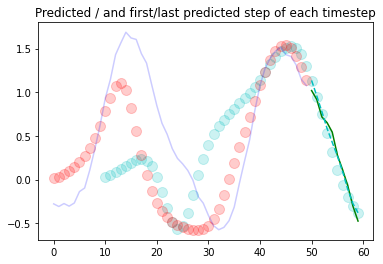

In [46]:
from matplotlib import pyplot as plt
Y_pred = model3.predict(X_test[:1])

plt.title("Predicted / and first/last predicted step of each timestep")
plt.plot(np.arange(50), X_test[:1].squeeze(), c = 'b', alpha = 0.2)
plt.plot(np.arange(60)[-10:], Y_test[:1, -1:, :].squeeze(), c = 'g')
plt.plot(np.arange(60)[-10:], Y_pred[:1, -1:, :].squeeze(), c = 'c', linestyle = '--')
for i in range(50):
    yp = Y_pred[:1, i, :1].squeeze()
    yp2 = Y_pred[:1, i, -1:].squeeze()
    plt.scatter(i, yp, s = 100, c = 'r', alpha = 0.2)
    plt.scatter(i + 10, yp2, s = 100, c = 'c', alpha = 0.2)